# Exploring Tesser Data Using Succersor Representation  Models

In [4]:
# main_tesser
import numpy as np
import scipy.spatial.distance as spsd
import matplotlib.pyplot as plt
import random
import math
import pandas as pd
import make_data as mkdt
import learning as ln

dir_path = '/home/rodrigo/Dropbox/tesser_successor/Data/'

data, dl = mkdt.get_data(dir_path)

In [57]:


def make_M_Matrix(dir):  
	envsteps= ln.make_envstep(dir)
	M  = ln.SRclass_nathum_exp1(envsteps, 0.5, 0.5,[0.5,0.5]) #W, mem, total_episodes
	return M


def initial_subj_run(num):
	count = []
	for i in range(0, len(dl), 11):
		count.append(i)
	return count[num]

In [58]:
def main_opt (option, subj_num):
	gamma = 	alpha = .5
	figsize=(70,30)
	size = 50
	a = initial_subj_run(subj_num)
	fig, axs = plt.subplots(2, 6, figsize=figsize ,sharex='col', sharey='row')
#     plt.suptitle(dl[a][:17]  + "  Subject " + dl[a][11:14] + "\n", size = 80)
#     plt.colorbar()
	plt.subplots_adjust(hspace=0.5)
	title_1 = " Part_" + str(1)#dl[a][:17] + " Part_" + str(1)
	title_2 = " Part_" + str(2)#dl[a][:17] + " Part_" + str(2)
	
	# This option allows the SR matrix to persist across all runs from Part 1 and Part 2
	#     without ever resetting.
	if option == 'persist':
		plt.suptitle("Persistent Learning: " + dl[a][:17]  + "  Subject " + dl[a][11:14] + "\n", size = 80)
		M = np.zeros([21,21])
		for part in [1,2]:
			for run in range(0,4+part):
				if part == 1:
					M = make_M_Matrix(a + run)
#                     axs[part-1, run].matshow(M)
					axs[part-1, run].matshow(M, cmap='viridis', vmin=0, vmax=1)
					axs[part-1, run].set_title(title_1 + " Run_" + dl[a + run][-5] + "\n", size=size)
				if part == 2:
					M = make_M_Matrix(a + 5 + run)
#                     axs[part-1, run].matshow(M)
					axs[part-1, run].matshow(M, cmap='viridis', vmin=0, vmax=1)
					axs[part-1, run].set_title(title_2 + " Run_" + dl[a + 5 + run][-5] + "\n", size=size)
		return plt.show()

	# This option allows the SR matrix to persist in Part 1 and Part 2, but resets it between them.
	if option == 'reset':
		plt.suptitle("Reset Learning: " + dl[a][:17]  + "  Subject " + dl[a][11:14] + "\n", size = 80)
		M = np.zeros ([21,21])
		is_reset = False
		for part in [1,2]:
			for run in range(0,4+part):
				if not is_reset and part == 2:
					M = np.zeros ([21,21])
					is_reset = True
				if part == 1:
					M = make_M_Matrix(a + run)
					axs[part-1, run].matshow(M)
					axs[part-1, run].set_title(title_1 + " Run_" + dl[a + run][-5] + "\n", size=size)
				if part == 2:
					M = make_M_Matrix(a + 5 + run)
					axs[part-1, run].matshow(M)
					axs[part-1, run].set_title(title_2 + " Run_" + dl[a + 5 + run][-5] + "\n", size=size)
		return plt.show()

	# This option resets the SR matrix between each run.
	if option == 'independent':
		plt.suptitle("Independent Learning: " + dl[a][:17]  + "  Subject " + dl[a][11:14] + "\n", size = 80)
		for part in [1,2]:
			for run in range(0,4+part):
				if part == 1:
					M = make_M_Matrix(a + run)
					axs[part-1, run].matshow(M)
					axs[part-1, run].set_title(title_1 + " Run_" + dl[a + run][-5] + "\n", size=size)
				if part == 2:
					M = make_M_Matrix(a + 5 + run)
					axs[part-1, run].matshow(M)
					axs[part-1, run].set_title(title_2 + " Run_" + dl[a + 5 + run][-5] + "\n", size=size)
		return plt.show()

	# This option forces the SR matrix to persist across all runs, but instead of plotting the SR matrix
	#     after each run, it plots the changes made to it after learning each object sequence.
	if option == 'track changes':
		plt.suptitle("Learning w/ Changes: " + dl[a][:17]  + "  Subject " + dl[a][11:14] + "\n", size = 80)
		M = np.zeros([21,21])
		for part in [1,2]:
			for run in range(0,4+part):
				if part == 1:
					envsteps = ln.make_envstep(a + run)
					M_new = np.copy(M)
					M_new = ln.SRclass_nathum_exp1(envsteps, gamma, alpha, M_new)
					axs[part-1, run].matshow(M_new-M,vmin=-.1,vmax=.1,cmap="RdBu_r")
#                     axs[part-1, run].colorbar()
					axs[part-1, run].set_title(title_1 + " Run_" + dl[a + run][-5] + "\n", size=size)
					M = M_new
				if part == 2:
					envsteps = ln.make_envstep(a + 5 + run)
					M_new = np.copy(M)
					M_new = ln.SRclass_nathum_exp1(envsteps, gamma, alpha, M_new)
					axs[part-1, run].matshow(M_new-M,vmin=-.1,vmax=.1,cmap="RdBu_r")
#                     axs[part-1, run].colorbar()
					axs[part-1, run].set_title(title_2 + " Run_" + dl[a + 5 + run][-5] + "\n", size=size)
					M = M_new
		return plt.show()

    
def indiv(subject_number):
	i = subject_number
	main_opt('persist', i)
#     main('reset', i)
#     main('independent', i)
#     main('track changes', i)


def make_rdm(subj_num, a,gamma, alpha):
	envsteps = ln.make_envstep(a)
	M = ln.SRclass_nathum_exp1(envsteps, gamma, alpha, 0.5)
	rdm = spsd.squareform(spsd.pdist(M, 'correlation'))
	return rdm


def track_alpha_change(subj_num):
    
	a = initial_subj_run(subj_num)
	fig, axs = plt.subplots(2,5, figsize=(20,10))
	plt.suptitle("Trancking RDM with " r'$\alpha$ change 0 to 1: ' + dl[a][:17]  + "  Subject " + dl[a][11:14] + " Part 1 Run 5""\n", 
				 fontweight="bold", size = (20), ha = 'center')
	for ax,count,i in zip(axs.flat, range(10, 110, 10),range(0,10)):
		alpha = count/100
		x = make_rdm(subj_num, a + i ,0.5, alpha)
		im = ax.matshow(x, cmap='viridis', vmin=-.1, vmax=.1)
		ax.set_title("Alpha = " + str(alpha),y=1.10)

	cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink = .85)
	cbar.set_label('Color Bar')


def track_alpha_with_learning_rmd_change(subj_num,gamma):

	for x in range(10,110,10):
		gamma = gamma
		alpha = x/100
		r = 7.5
		c = 5
		M = np.zeros([21,21])  
		a = initial_subj_run(subj_num)

		fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(r, c))
		plt.suptitle("Trancking RDM with Learning and " r"$\alpha$ "" Change " + "\n"
					 + dl[a][:17] + "  Subject " + dl[a][11:14] + "  "r'$\alpha$ : ' + str(alpha) + "\n", 
				 fontweight="bold", size = (10), ha = 'center',y=1.10)
		plt.subplots_adjust(hspace=1)
		title_1 = " Part_" + str(1)#dl[a][:17] + " Part_" + str(1)

		for run in [0,1,2,3,4]:
			if run < 3:
				row = 0
				ax = axes[row,run]
				envsteps = ln.make_envstep(a + run)
				M_new = np.copy(M)
				M_new = ln.SRclass_nathum_exp1(envsteps, gamma, alpha, np.copy(M))
				rdm = spsd.squareform(spsd.pdist(M_new, 'correlation'))
				ax.set_title(title_1 + " Run_" + dl[a + run][-5] + "\n")
				im = ax.imshow(rdm, cmap='viridis', vmin=0, vmax=1)
				M = M_new

			if run > 2:
				row = 1
				run2 = run - 3
				ax = axes[row,run2]
				envsteps = ln.make_envstep(a + run)
				M_new = np.copy(M)
				M_new = ln.SRclass_nathum_exp1(envsteps, gamma, alpha, np.copy(M))
				ax.set_title(title_1 + " Run_" + dl[a + run][-5] + "\n")
				rdm = spsd.squareform(spsd.pdist(M_new, 'correlation'))
				im = ax.imshow(rdm, cmap='viridis', vmin=0, vmax=1)
				M = M_new
                
			if run == 4:
				fig.delaxes(axes[1][2])

		cbar = fig.colorbar(im, ax=axes.ravel().tolist())
		cbar.set_label('Color Bar')
       
	return plt.show()

In [80]:
# for i in range(0,(len(dl)//11)):
#     indiv(i)

In [109]:
def my_function(dic):
    for x in range(len(dic)):
        if len(dic[x]) == 0:
            del dic[x]
        else:
            continue
    return dic

def missing_obj():

    # loops over every data set
    index = []
    t = {}
    for i in range(0,len(dl)):

        l = list(range(1,22))
        read_data = data[dl[i]][" objnum"]
        j = []
        g = []
        e = {}
        # loops over every trial to create a searchable list
        for k in range(0,len(read_data)):
            n = int(read_data[k])
            j.append(n)
        count = 0
        # loops over every objnum and sees if it is in the data set
        for h in range(0,len(l)):

            if l[h] not in j:

                index.append(i)
                m = n + count
                g.append(m)

#                 print("Subject " + dl[i][11:14] + " is missing object " + str(m) + 
#                   " in "+ "Part " + dl[i][-11] + " and Run: " + dl[i][-5])
                count +=1
                

            else:
                continue
            
        t.update({i:g})

    my_list= my_function(t)
    new_list =list(my_list.keys())
    for f in new_list:
        d = my_list[f]
        s = (17 - len(str(d))) *' '
        print("Subject " + dl[f][11:14] + " is missing object/s "+ str(d) + s +
              " from " + "Part " + dl[f][-11] + " and Run: " + dl[f][-5] + "         Directory #" +str(f))

missing_obj()


Subject 100 is missing object/s [2]               from Part 1 and Run: 1         Directory #0
Subject 101 is missing object/s [10]              from Part 1 and Run: 3         Directory #13
Subject 103 is missing object/s [13, 14, 15]      from Part 1 and Run: 4         Directory #36
Subject 104 is missing object/s [8]               from Part 1 and Run: 2         Directory #45
Subject 108 is missing object/s [5, 6]            from Part 1 and Run: 2         Directory #89
Subject 108 is missing object/s [6, 7, 8]         from Part 1 and Run: 4         Directory #91
Subject 112 is missing object/s [13, 14, 15, 16]  from Part 1 and Run: 4         Directory #135
Subject 112 is missing object/s [1]               from Part 2 and Run: 3         Directory #139
Subject 113 is missing object/s [7, 8, 9, 10]     from Part 1 and Run: 4         Directory #146
Subject 115 is missing object/s [17]              from Part 1 and Run: 4         Directory #168
Subject 116 is missing object/s [20, 21]       

In [90]:
def fix(matrix):
    new_matrix = matrix
    new_matrix[new_matrix == 0] = 0.0000001
    return new_matrix

In [91]:
def track_alpha_with_learning_rmd_change(subj_num,gamma):

	for x in range(10,110,10):
		gamma = gamma
		alpha = x/100
		r = 7.5
		c = 5
		M = np.zeros([21,21])  
		a = initial_subj_run(subj_num)

		fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(r, c))
		plt.suptitle("Trancking RDM with Learning and " r"$\alpha$ "" Change " + "\n"
					 + dl[a][:17] + "  Subject " + dl[a][11:14] + "  "r'$\alpha$ : ' + str(alpha) + "\n", 
				 fontweight="bold", size = (10), ha = 'center',y=1.10)
		plt.subplots_adjust(hspace=1)
		title_1 = " Part_" + str(1)#dl[a][:17] + " Part_" + str(1)

		for run in [0,1,2,3,4]:
			if run < 3:
				row = 0
				ax = axes[row,run]
				envsteps = ln.make_envstep(a + run)
				M_new = np.copy(M)
				M_new = fix(ln.SRclass_nathum_exp1(envsteps, gamma, alpha, np.copy(M)))
				rdm = spsd.squareform(spsd.pdist(M_new, 'correlation'))
				ax.set_title(title_1 + " Run_" + dl[a + run][-5] + "\n")
				im = ax.imshow(rdm, cmap='viridis', vmin=0, vmax=1)
				M = M_new

			if run > 2:
				row = 1
				run2 = run - 3
				ax = axes[row,run2]
				envsteps = ln.make_envstep(a + run)
				M_new = np.copy(M)
				M_new = fix(ln.SRclass_nathum_exp1(envsteps, gamma, alpha, np.copy(M)))
				ax.set_title(title_1 + " Run_" + dl[a + run][-5] + "\n")
				rdm = spsd.squareform(spsd.pdist(M_new, 'correlation'))
				im = ax.imshow(rdm, cmap='viridis', vmin=0, vmax=1)
				M = M_new
                
			if run == 4:
				fig.delaxes(axes[1][2])

		cbar = fig.colorbar(im, ax=axes.ravel().tolist())
		cbar.set_label('Color Bar')
       
	return plt.show()

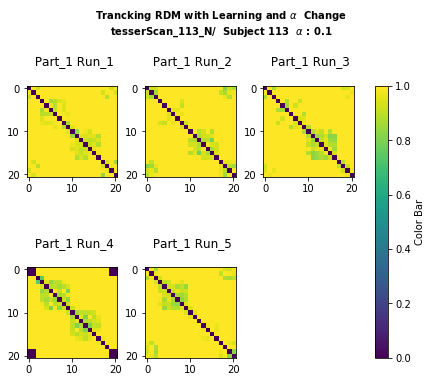

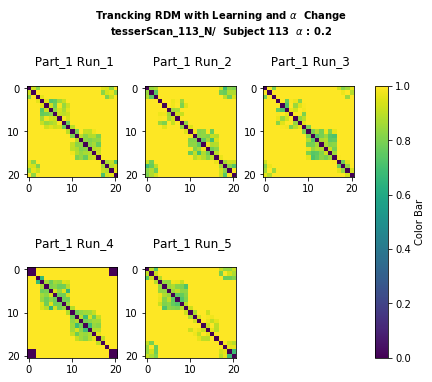

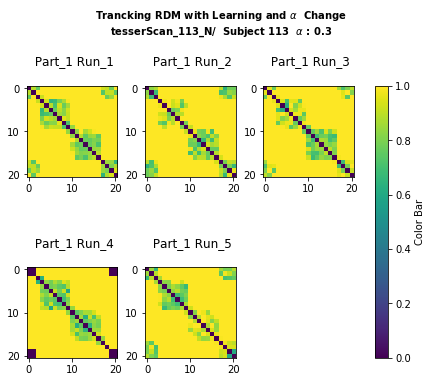

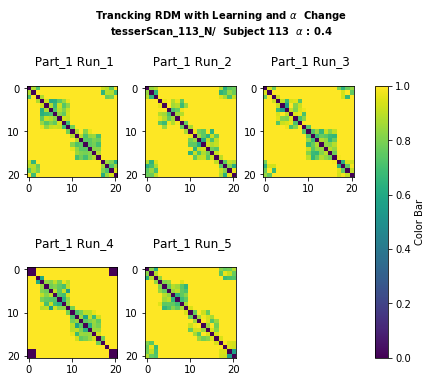

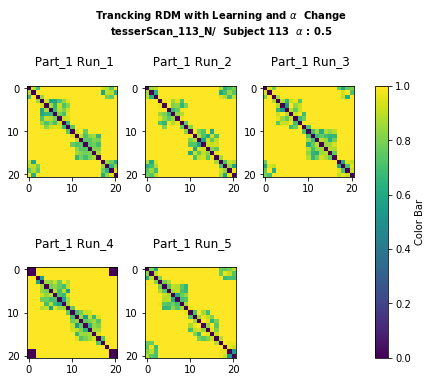

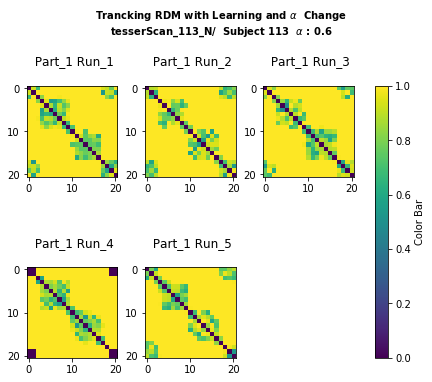

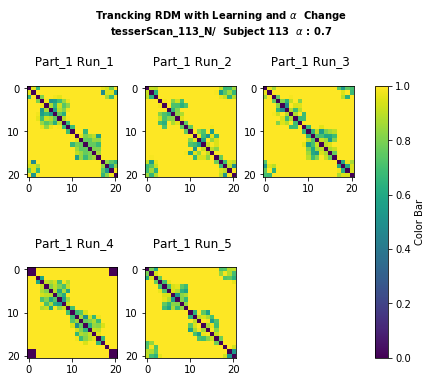

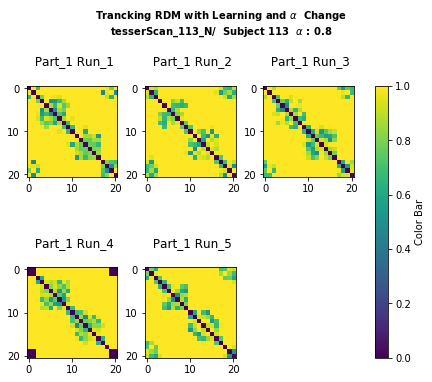

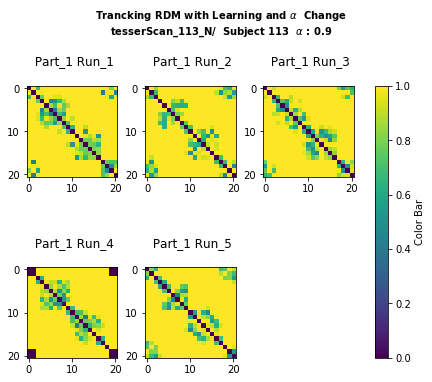

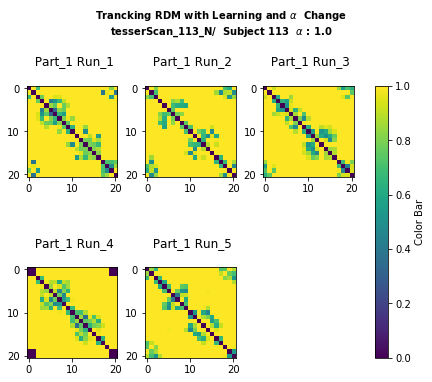

In [92]:
track_alpha_with_learning_rmd_change(subj_num = 13, gamma = 0.5)